In [3]:
# External Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, LSTM, Embedding, Reshape, SimpleRNN, MaxPooling1D, Conv1D
from keras import initializers
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re 

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

#### Utility Functions

In [66]:
# Functions 

def CountPlot(data, title):
    plot = plt.axes()
    plot.set_title(title)
    sns.countplot(data)
    plot.set_xlabel('label')
    plot.set_xticklabels(['Fake(0)','Real(1)'])
    return plot

def CorpusGen(text):
    # Removes numbers, lowercases words, removes stopwords, word tokenizes, and finally lemmantizes
    lemmatizer = WordNetLemmatizer()
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')
    nltk.download('omw-1.4')

    corpus = []
    for i in range(0,len(text)):
        message = re.sub('[^a-zA-Z]', ' ', text.iloc[i])
        message = message.lower()
        message = word_tokenize(message)
        message = [lemmatizer.lemmatize(w) for w in message if not w in stopwords.words('english')]
        message = ' '.join(message)
        corpus.append(message)
    return corpus

def PredAcc(prediction, data):
    correct = 0
    incorrect = 0
    total = 0
    binary_pred = []
    for i in range(len(binary_pred)):
        if(binary_pred[i] == data.loc[i,'label']):
            correct += 1
        else:
            incorrect += 1

    total = correct + incorrect

def plot(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

### Importing Dataset

In [67]:

filepath = "Data/WELFake_Dataset.csv"

raw_data = pd.read_csv(filepath)


### Data Cleaning

In [68]:

cols = [x for x in raw_data.columns if x in ['title', 'text', 'label']]
clean_data = raw_data[cols]
clean_data.dropna(axis=0, inplace=True)
print(clean_data.shape)
clean_data.head()

(71537, 3)


,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1


### EDA

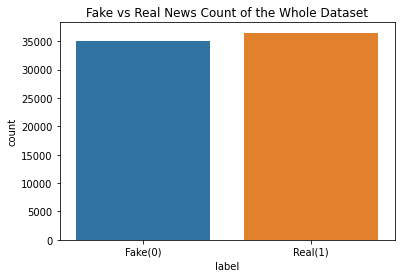

In [69]:
fulldata_countplot = CountPlot(clean_data['label'], 'Fake vs Real News Count of the Whole Dataset')

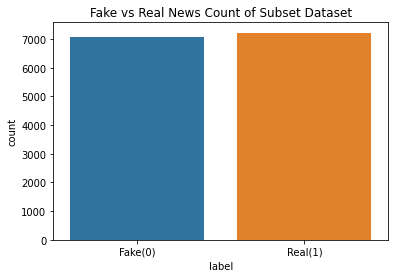

In [18]:
subsetdata_countplot = CountPlot(subset_data_one['label'], 'Fake vs Real News Count of Subset Dataset')

### Generating Data Corpus

In [71]:
corpus_one = CorpusGen(clean_data['text'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/liamwebster/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/liamwebster/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/liamwebster/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/liamwebster/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [72]:
# Tokenize text

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus_one)
word_index = tokenizer.word_index
vocab_size=len(word_index)
sequences = tokenizer.texts_to_sequences(corpus_one)

Percentage of Articles with length less than 600 words:  89.33389250017474


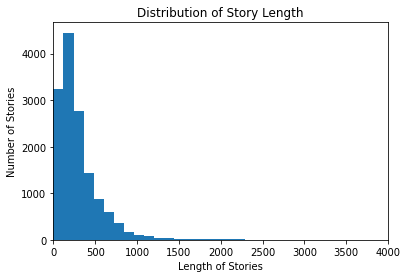

In [22]:
list = []
count = 0
for i in range(14307):
    length = len(sequences[i])
    list.append(length)
    if length <= 600:
        count += 1

plt.hist(list, bins=100)
plt.xlim(0,4000)
plt.xlabel('Length of Stories')
plt.ylabel('Number of Stories')
plt.title('Distribution of Story Length')
percent = count / len(sequences)
print('Percentage of Articles with length less than 600 words:  ' + str((count / len(sequences) * 100)))

In [74]:

padded = pad_sequences(sequences, maxlen=600, padding='post', truncating='post')
X_train, X_test, y_train, y_test = train_test_split(padded,clean_data['label'], test_size=0.2, random_state=42)

In [75]:
embeddings_index = {};
with open('Data/glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
print(len(coefs))

embeddings_matrix = np.zeros((vocab_size+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

100


### Model 1

In [45]:
rnn_hidden_dim = 10
model_rnn1 = Sequential()
model_rnn1.add(Embedding(vocab_size + 1, 100, weights=[embeddings_matrix], trainable=False)) 
model_rnn1.add(LSTM(rnn_hidden_dim, return_sequences=True))
model_rnn1.add(Dense(1, activation='sigmoid'))

In [46]:
rmsprop = keras.optimizers.RMSprop(lr = .01)

model_rnn1.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

In [47]:
model_rnn1.fit(X_train, y_train,
          batch_size=64,
          epochs=5,
          validation_data=(X_test, y_test))

Epoch 1/5
179/179 [==============================] - 22s 115ms/step - loss: 0.5088 - accuracy: 0.7494 - val_loss: 0.4860 - val_accuracy: 0.7434
Epoch 2/5
179/179 [==============================] - 20s 110ms/step - loss: 0.3592 - accuracy: 0.8463 - val_loss: 0.3188 - val_accuracy: 0.8723
Epoch 3/5
179/179 [==============================] - 20s 112ms/step - loss: 0.3182 - accuracy: 0.8702 - val_loss: 0.3323 - val_accuracy: 0.8758
Epoch 4/5
179/179 [==============================] - 20s 111ms/step - loss: 0.2708 - accuracy: 0.8875 - val_loss: 0.2546 - val_accuracy: 0.8902
Epoch 5/5
179/179 [==============================] - 20s 112ms/step - loss: 0.2385 - accuracy: 0.9008 - val_loss: 0.2447 - val_accuracy: 0.8920


### Model 2

In [43]:
rnn_hidden_dim = 20
model_rnn2 = Sequential()
model_rnn2.add(Embedding(vocab_size + 1, 100, weights=[embeddings_matrix], trainable=False))  
model_rnn2.add(Dropout(0.2))
model_rnn2.add(LSTM(rnn_hidden_dim, return_sequences=True))
model_rnn2.add(Dropout(0.2))
model_rnn2.add(Dense(256))
model_rnn2.add(Dense(1, activation='sigmoid'))

In [44]:
rmsprop = keras.optimizers.RMSprop(lr = .01)

model_rnn2.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

In [42]:
model_rnn2.fit(X_train, y_train,
          batch_size=64,
          epochs=10,
          validation_data=(X_test, y_test))

Epoch 1/10
179/179 [==============================] - 33s 177ms/step - loss: 0.5682 - accuracy: 0.7261 - val_loss: 0.4205 - val_accuracy: 0.8475
Epoch 2/10
179/179 [==============================] - 31s 173ms/step - loss: 0.4077 - accuracy: 0.8392 - val_loss: 0.3275 - val_accuracy: 0.8728
Epoch 3/10
179/179 [==============================] - 31s 174ms/step - loss: 0.3346 - accuracy: 0.8680 - val_loss: 0.3217 - val_accuracy: 0.8817
Epoch 4/10
179/179 [==============================] - 31s 175ms/step - loss: 0.3097 - accuracy: 0.8828 - val_loss: 0.4629 - val_accuracy: 0.8117
Epoch 5/10
179/179 [==============================] - 31s 174ms/step - loss: 0.2821 - accuracy: 0.8925 - val_loss: 0.2562 - val_accuracy: 0.9065
Epoch 6/10
179/179 [==============================] - 31s 174ms/step - loss: 0.2407 - accuracy: 0.9056 - val_loss: 0.2403 - val_accuracy: 0.9079
Epoch 7/10
179/179 [==============================] - 32s 180ms/step - loss: 0.2461 - accuracy: 0.9063 - val_loss: 0.2323 - val_ac

### Model 3

In [76]:
rnn_hidden_dim = 20
model_rnn3 = Sequential()
model_rnn3.add(Embedding(vocab_size+1, 100, weights=[embeddings_matrix], trainable=False))
model_rnn3.add(Dropout(0.2))
model_rnn3.add(Conv1D(64, 5, activation='relu'))
model_rnn3.add(MaxPooling1D(pool_size=4))
model_rnn3.add(LSTM(20, return_sequences=True))
model_rnn3.add(LSTM(20))
model_rnn3.add(Dropout(0.2))
model_rnn3.add(Dense(512))
model_rnn3.add(Dropout(0.3))
model_rnn3.add(Dense(256))
model_rnn3.add(Dense(1, activation='sigmoid'))

Epoch 1/10
573/573 [==============================] - 152s 258ms/step - loss: 0.3682 - accuracy: 0.8275 - val_loss: 0.1999 - val_accuracy: 0.9219
Epoch 2/10
573/573 [==============================] - 143s 249ms/step - loss: 0.1862 - accuracy: 0.9286 - val_loss: 0.1488 - val_accuracy: 0.9395
Epoch 3/10
573/573 [==============================] - 181s 316ms/step - loss: 0.1405 - accuracy: 0.9471 - val_loss: 0.1172 - val_accuracy: 0.9558
Epoch 4/10
573/573 [==============================] - 141s 246ms/step - loss: 0.1198 - accuracy: 0.9541 - val_loss: 0.1133 - val_accuracy: 0.9593
Epoch 5/10
573/573 [==============================] - 141s 246ms/step - loss: 0.1040 - accuracy: 0.9601 - val_loss: 0.1181 - val_accuracy: 0.9611
Epoch 6/10
573/573 [==============================] - 139s 243ms/step - loss: 0.0957 - accuracy: 0.9633 - val_loss: 0.0972 - val_accuracy: 0.9637
Epoch 7/10
573/573 [==============================] - 140s 245ms/step - loss: 0.0878 - accuracy: 0.9675 - val_loss: 0.1035 -

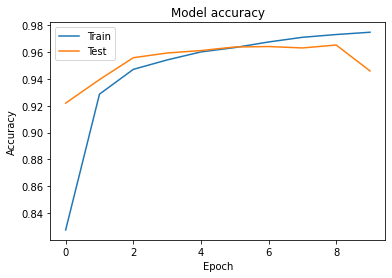

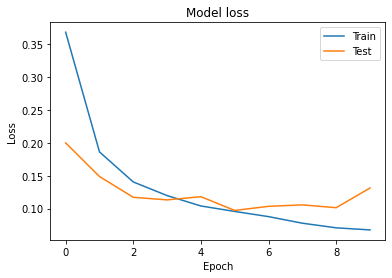

In [77]:

model_rnn3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model_rnn3.fit(X_train, y_train, 
                    epochs=10, 
                    batch_size=100, 
                    validation_data=(X_test, y_test))
plot(history)

In [99]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

model_rnn3.save("final_model_tf", save_format='tf')
print("Successfully Saved Model to Disk")

INFO:tensorflow:Assets written to: final_model_tf/assets


INFO:tensorflow:Assets written to: final_model_tf/assets


Successfully Saved Model to Disk


### Testing Final Model(Model 3) on another Dataset

In [79]:
filepath = "Data/fake_or_real_news.csv"

raw_data2 = pd.read_csv(filepath)

# Data Cleaning
cols = ['title', 'text', 'label']
clean_data2 = raw_data2[cols]
clean_data2.dropna(axis=0, inplace=True)
print(clean_data2.shape)
clean_data2.head()

(6335, 3)


,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [80]:

clean_data2.replace('FAKE', 0, inplace=True)
clean_data2.replace('REAL', 1, inplace=True)
clean_data2.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


In [81]:
corpus_two = CorpusGen(clean_data2['text'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/liamwebster/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/liamwebster/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/liamwebster/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/liamwebster/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [82]:
sequences2 = tokenizer.texts_to_sequences(corpus_two)
padded2 = pad_sequences(sequences2, maxlen=600, padding='post', truncating='post')


In [88]:
prediction2 = model_rnn3.predict(padded2)

198/198 [==============================] - 6s 32ms/step


In [94]:
binary_pred = []
for i in range(len(prediction2)):
    if (prediction2[i] > 0.50):
        binary_pred.append(1)
    else:
        binary_pred.append(0)


In [95]:
correct = 0
incorrect = 0
total = 0
for i in range(len(binary_pred)):
    if(binary_pred[i] == clean_data2.loc[i,'label']):
        correct += 1
    else:
        incorrect += 1

total = correct + incorrect

In [98]:
correct / total * 100

98.27940015785319

Epoch 1/10
51/51 [==============================] - 13s 262ms/step - loss: 0.7409 - accuracy: 0.5414 - val_loss: 0.6580 - val_accuracy: 0.6006
Epoch 2/10
51/51 [==============================] - 14s 270ms/step - loss: 0.6270 - accuracy: 0.6180 - val_loss: 0.5377 - val_accuracy: 0.7056
Epoch 3/10
51/51 [==============================] - 15s 293ms/step - loss: 0.5086 - accuracy: 0.7575 - val_loss: 0.3371 - val_accuracy: 0.8792
Epoch 4/10
51/51 [==============================] - 14s 267ms/step - loss: 0.2852 - accuracy: 0.8964 - val_loss: 0.1399 - val_accuracy: 0.9590
Epoch 5/10
51/51 [==============================] - 13s 256ms/step - loss: 0.1657 - accuracy: 0.9451 - val_loss: 0.1163 - val_accuracy: 0.9653
Epoch 6/10
51/51 [==============================] - 13s 252ms/step - loss: 0.1214 - accuracy: 0.9599 - val_loss: 0.1692 - val_accuracy: 0.9337
Epoch 7/10
51/51 [==============================] - 12s 242ms/step - loss: 0.1451 - accuracy: 0.9503 - val_loss: 0.2069 - val_accuracy: 0.9503

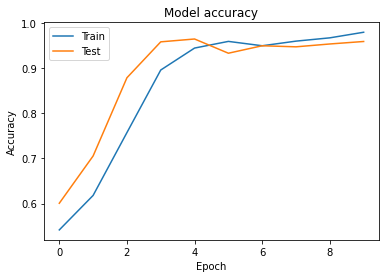

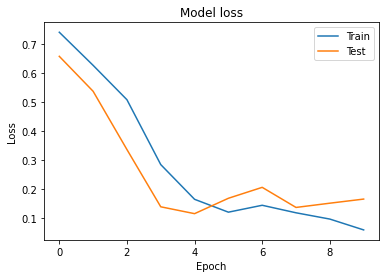

In [87]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(padded2,clean_data2['label'], test_size=0.2, random_state=42)
history = model_rnn3.fit(X_train2, y_train2, 
                    epochs=10, 
                    batch_size=100, 
                    validation_data=(X_test2, y_test2))
plot(history)

In [1]:
model_rnn3.summary

NameError: name 'model_rnn3' is not defined

In [4]:
loaded_model = keras.models.load_model("final_model_tf")


In [6]:
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         19208700  
                                                                 
 dropout_3 (Dropout)         (None, None, 100)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 64)          32064     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, None, 20)          6800      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3280      
                                                      